<a href="https://colab.research.google.com/github/bt22dr/deep-learning-papers/blob/master/code/cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고한 소스
 * https://gist.github.com/danijar/1cb4d81fed37fd06ef60d08c1181f557
 * https://github.com/hwalsuklee/tensorflow-generative-model-collections/blob/master/VAE.py
 * https://github.com/altosaar/variational-autoencoder/blob/master/vae.py

In [14]:
!pip install imageio

In [1]:
%matplotlib inline

import os
import sys
import glob
import imageio
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tfd = tf.contrib.distributions

print(tf.__version__)

1.13.0-rc0


In [0]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


![큰 그림에서의 각 모듈간의 관계도](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/modules.png?raw=1)
출처: Variational Inference and Deep Learning: A New Synthesis

In [0]:
def encoder(x, z_dim=100, n_units=256):
    h1 = tf.layers.dense(x, n_units, activation=tf.nn.leaky_relu)
    h2 = tf.layers.dense(h1, n_units, activation=tf.nn.leaky_relu)
    mu = tf.layers.dense(h2, z_dim, activation=None)
    sigma = tf.layers.dense(h2, z_dim, activation=tf.nn.softplus)

    return mu, sigma

In [0]:
def decoder(z, n_units=256):
    h1 = tf.layers.dense(z, n_units, activation=tf.nn.leaky_relu)
    h2 = tf.layers.dense(h1, n_units, activation=tf.nn.leaky_relu)
    x = tf.layers.dense(h2, x_dim, activation=None) # tf.nn.sigmoid

    return x

In [0]:
encoder = tf.make_template('encoder', encoder)
decoder = tf.make_template('decoder', decoder)

In [0]:
x_dim = 28*28
z_dim = 2
inputs_x = tf.placeholder(tf.float32, (None, x_dim), name='input_x')
inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')

![architecture](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/architecture01.png?raw=1)
![architecture](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/architecture02.png?raw=1)

In [8]:
# posterior, q(z|x), encoder
q_mu, q_sigma = encoder(inputs_x, z_dim=z_dim)
q_z_given_x = tfd.Normal(q_mu, q_sigma) # tfd.MultivariateNormalDiag(mu, sigma)
z_samples = q_z_given_x.sample()

# likelihood, p(x|z), decoder
p_x_given_z_logits = decoder(z_samples)
p_x_given_z = tfd.Bernoulli(logits=p_x_given_z_logits)

# prior, p(z), standard distribution
p_z = tfd.Normal(np.zeros(z_dim, dtype=np.float32), np.ones(z_dim, dtype=np.float32))

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [9]:
# visualization
sample_dim = 10
z_samples_stddist = p_z.sample(sample_dim)

p_x_given_z_logits_from_stddist = decoder(z_samples_stddist)
p_x_given_z_stddist = tfd.Bernoulli(logits=p_x_given_z_logits_from_stddist)
p_x_given_z_stddist_mean = tfd.Independent(p_x_given_z_stddist).mean()
p_x_given_z_stddist_sample = p_x_given_z_stddist.sample()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


![ELBO equation](https://github.com/bt22dr/deep-learning-papers/blob/master/code/images/vae/elbo_equation.png?raw=1)

In [10]:
divergence = tf.reduce_sum(tfd.kl_divergence(q_z_given_x, p_z))
likelihood = tf.reduce_sum(p_x_given_z.log_prob(inputs_x))
elbo = tf.reduce_mean(-divergence + likelihood)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(-elbo)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [0]:
def plot_codes(ax, codes, labels):
    ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax.set_aspect('equal')
    #ax.set_xlim(codes.min() - .1, codes.max() + .1)
    #ax.set_ylim(codes.min() - .1, codes.max() + .1)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.tick_params(axis='both', which='both', left='off', bottom='off', labelleft='off', labelbottom='off')

def plot_samples(ax, samples):
    for index, sample in enumerate(samples):
        ax[index].imshow(sample, cmap='gray')
        ax[index].axis('off')

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Epoch  0: 18285.695
Epoch  1: 17221.648
Epoch  2: 15883.818
Epoch  3: 16087.52
Epoch  4: 15299.392
Epoch  5: 14670.738
Epoch  6: 14618.576
Epoch  7: 15236.017
Epoch  8: 13896.244
Epoch  9: 14612.306
Epoch 10: 14999.089
Epoch 11: 13534.673
Epoch 12: 14528.102
Epoch 13: 14900.306
Epoch 14: 14457.543
Epoch 15: 14367.565
Epoch 16: 15318.737
Epoch 17: 15141.846
Epoch 18: 14101.215
Epoch 19: 14410.341


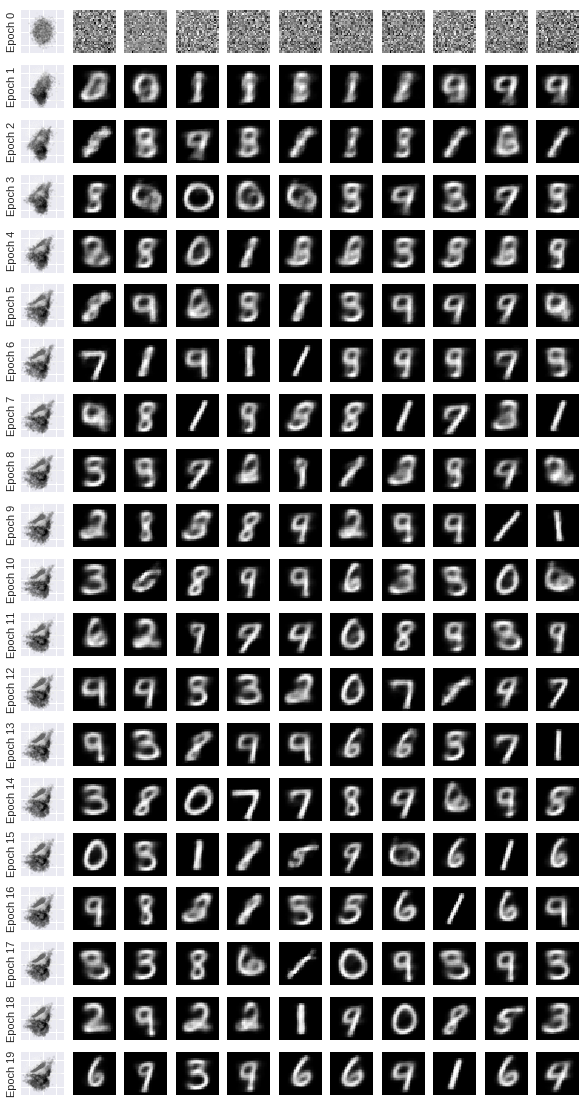

In [12]:
num_epochs = 20
batch_size = 100

sess = tf.Session()
sess.run(tf.global_variables_initializer())

fig, ax = plt.subplots(nrows=num_epochs, ncols=11, figsize=(10, num_epochs))
samples_std_dist = np.random.normal(0, 1, (sample_dim, z_dim)).astype(np.float32)
for epoch in range(num_epochs):
    x_test = mnist.test.images
    feed = {inputs_x: x_test, inputs_z: samples_std_dist}
    np_z, np_x_mean = sess.run([z_samples, p_x_given_z_stddist_mean], feed)

    ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
    plot_codes(ax[epoch, 0], np_z, mnist.test.labels)
    plot_samples(ax[epoch, 1:], np.reshape(np_x_mean, (-1,28,28)))

    for ii in range(mnist.train.num_examples//batch_size):
        x_training, _ = mnist.train.next_batch(batch_size)
        np_elbo,_ = sess.run([elbo, optimizer], feed_dict={inputs_x: x_training})
    print("Epoch {:2}:".format(epoch), -np_elbo)

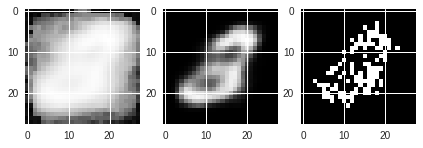

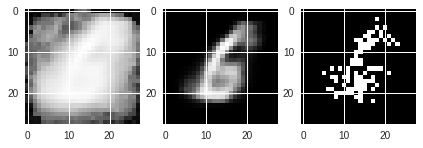

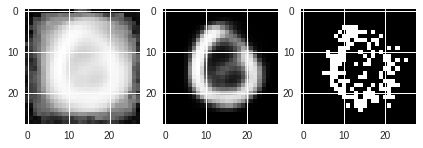

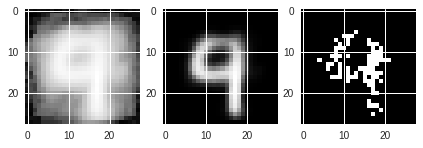

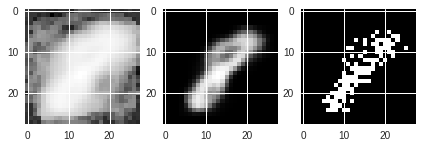

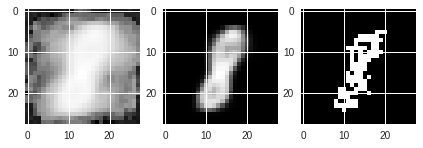

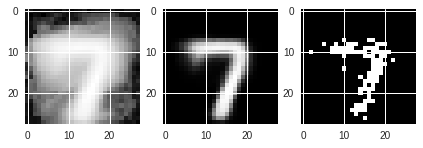

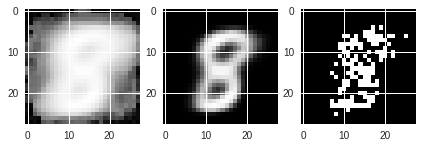

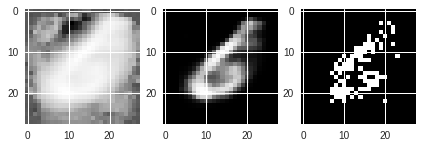

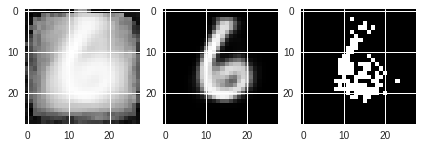

In [13]:
x_test = mnist.test.images
samples_std_dist = np.random.normal(0, 1, (sample_dim, z_dim)).astype(np.float32)
np_x_logit, np_x_mean, np_x_sample = sess.run(
    [p_x_given_z_logits_from_stddist, p_x_given_z_stddist_mean, p_x_given_z_stddist_sample], 
    feed_dict={inputs_x: x_test, inputs_z: samples_std_dist})

for i in range(10): # range(mnist.test.num_examples):
    x_logit = np.reshape(np_x_logit[i], (28,28))
    x_mean = np.reshape(np_x_mean[i], (28,28))
    x_sample = np.reshape(np_x_sample[i], (28,28))
    fig_tmp = plt.figure(figsize=(7,4))
    ax_tmp = fig_tmp.add_subplot(131)
    plt.imshow(x_logit, cmap='Greys_r')
    ax_tmp = fig_tmp.add_subplot(132)
    plt.imshow(x_mean, cmap='Greys_r')
    ax_tmp = fig_tmp.add_subplot(133)
    plt.imshow(x_sample, cmap='Greys_r')    